In [2]:



import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
from scipy.io import arff


#importo los modelos
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import  RobustScaler
from IPython.display import display
from joblib import dump, load
from xgboost import XGBClassifier

#importo las métricas

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score

#Librerias de validacion cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
f_zip = 'https://github.com/adiacla/bigdata/raw/master/adult.csv.zip'
r = requests.get(f_zip, stream=True)
adults_zip = zipfile.ZipFile(io.BytesIO(r.content))
adults_zip.extractall()

In [ ]:
data = pd.read_csv('adult.csv')
df = pd.DataFrame(data)
df

#Data Cleaning and preprocessing



Se ajusta el ingreso para facilitar el trabajo. Se asigna el valor 0 si es igual o inferior a 50 000 y se asigna el valor 1 si es superior a 50 000.

In [5]:
df.loc[df['income'] == '<=50K', ['income']] = 0
df.loc[df['income'] == '>50K',['income']] = 1
df.to_csv('adult2.csv', index = False)
df['income'].value_counts()
df['income']=df['income'].astype(int)

Se ajusta el sexo para facilitar el trabajo. Se asigna el valor 1 para hombres y el valor 0 para mujeres.

In [6]:
df.sex.value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

In [7]:
df.loc[df['sex'] == 'Female', ['sex']] = 0
df.loc[df['sex'] == 'Male',['sex']] = 1
df.to_csv('adult2.csv', index = False)

df['sex']=df['sex'].astype(int)
df['sex'].value_counts()

1    21790
0    10771
Name: sex, dtype: int64

"Education" y "education.num" describen lo mismo, excepto que "education.num" lo cuantifica. Por esta razón, eliminaremos ambas columnas.

"Fnlwgt" no aporta valor al modelo, por lo tanto, también puede ser eliminado.
'RELATIONSHIP' tampoco aporta valor a modelo

In [8]:
df=df.drop(['fnlwgt','education','relationship'],axis=1)

La función clasifica los estados civiles en 'single', 'married' o 'divorced'
basándose en ciertos criterios. Luego, cuenta las ocurrencias de cada categoría en la columna 'marital.status' del DataFrame.

In [9]:
df['marital.status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

In [10]:
#definiremos unicamente 3 estados civiles: soltero, casado, separado
def cambiar_estado_civil(e):
    if e in ['Never-married', 'Separated', 'Widowed']:
        return 'single'
    elif e in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'married'
    else:
        return 'divorced'

df['marital.status'] = df['marital.status'].apply(cambiar_estado_civil)

df['marital.status'].value_counts()


married     15417
single      12701
divorced     4443
Name: marital.status, dtype: int64

In [11]:
cate_columns = [col for col in df.columns if df[col].dtype == "O"]
cate_columns

['workclass', 'marital.status', 'occupation', 'race', 'native.country']

In [12]:
df["workclass"].mode()[0]

'Private'

In [13]:
#buscar valores con ? y reemplazarlos con NaN

def reemplazarNan(data,column):
  data[column] = data[column].replace('?', np.nan)
  return data

df = reemplazarNan(df, 'workclass')
df = reemplazarNan(df, 'occupation')
df = reemplazarNan(df, 'native.country')

In [14]:
df['workclass'].isnull().sum()

1836

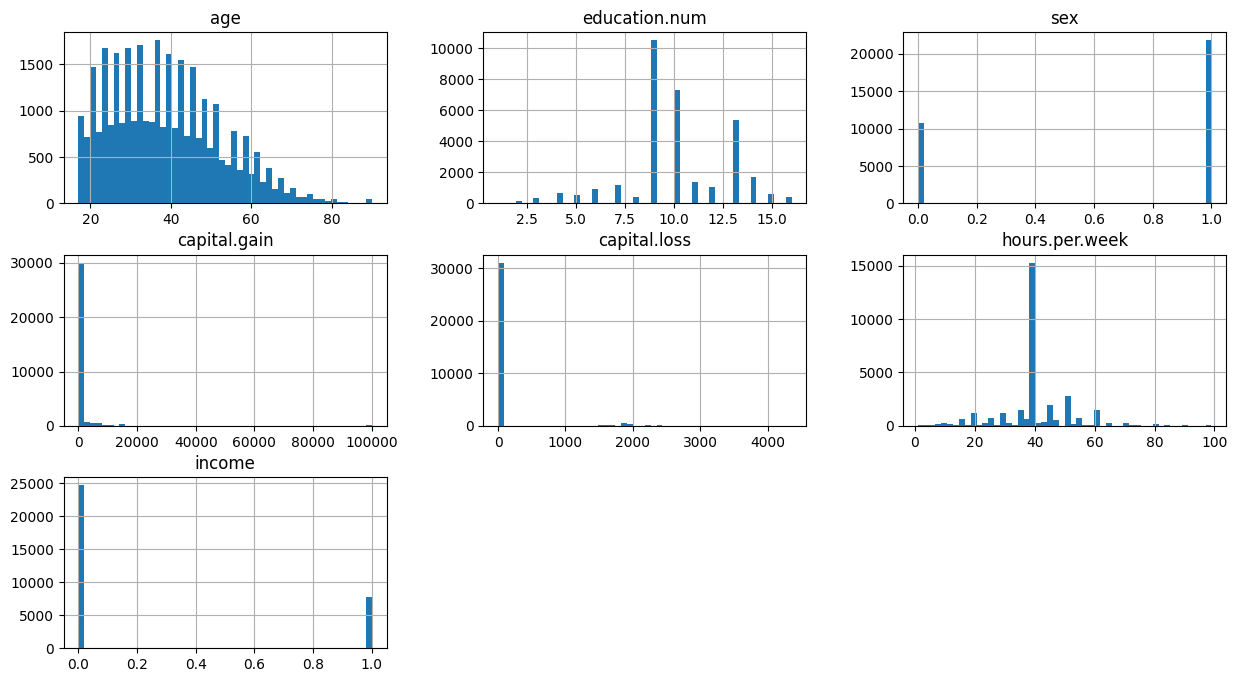

In [15]:
df.hist(figsize=(15, 8),bins = 50)
plt.show()

Matriz de correlacion

<Figure size 500x200 with 0 Axes>

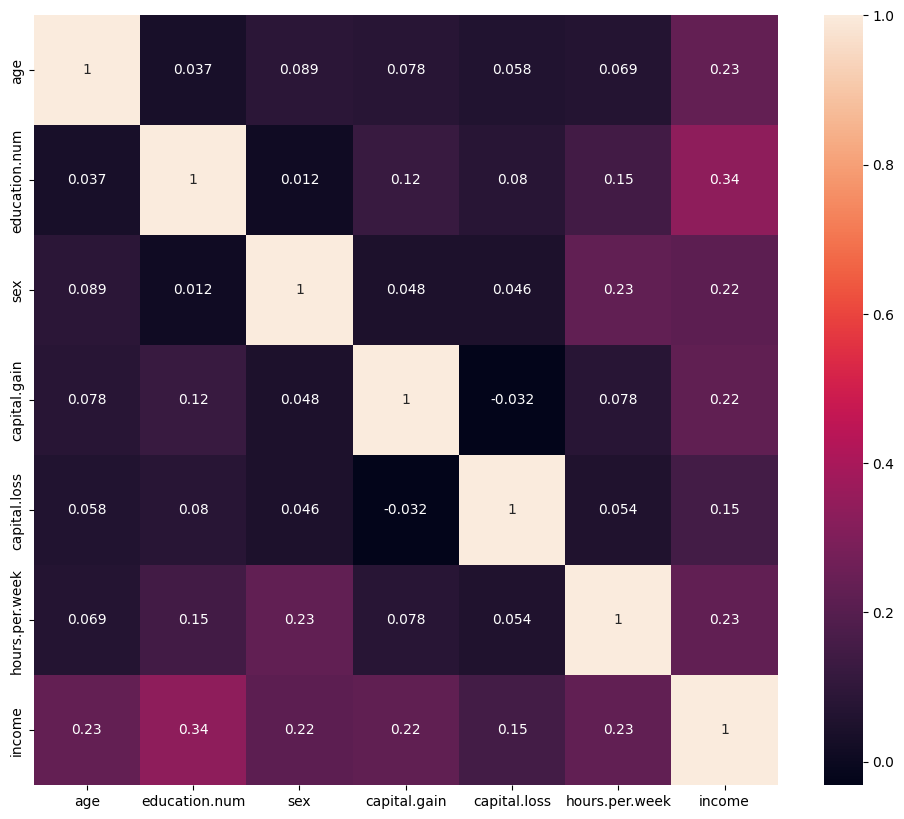

In [16]:
plt.figure(figsize=(5, 2))
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, )
plt.show()

In [17]:
#no tendremos en cuenta la columna capital.loss porque es la que mas baja correlacion presenta en el modelo
df=df.drop(['capital.loss'],axis=1)


In [18]:
df.head()

,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,hours.per.week,native.country,income
0,90,NaN,9,single,NaN,White,0,0,40,United-States,0
1,82,Private,9,single,Exec-managerial,White,0,0,18,United-States,0
2,66,NaN,10,single,NaN,Black,0,0,40,United-States,0
3,54,Private,4,divorced,Machine-op-inspct,White,0,0,40,United-States,0
4,41,Private,10,single,Prof-specialty,White,0,0,40,United-States,0


HAY QUE CODIFICAR TODAS LAS VARIABLES NOMINALES

In [19]:
label_encoder=LabelEncoder()
feature_list=['workclass', 'marital.status', 'occupation', 'race', 'native.country']
for i in feature_list:
    df[i] = label_encoder.fit_transform(df[i])
df.head()

,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,hours.per.week,native.country,income
0,90,8,9,2,14,4,0,0,40,38,0
1,82,3,9,2,3,4,0,0,18,38,0
2,66,8,10,2,14,2,0,0,40,38,0
3,54,3,4,0,6,4,0,0,40,38,0
4,41,3,10,2,9,4,0,0,40,38,0


#Crear modelo de Machine Learning

In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int64
 2   education.num   32561 non-null  int64
 3   marital.status  32561 non-null  int64
 4   occupation      32561 non-null  int64
 5   race            32561 non-null  int64
 6   sex             32561 non-null  int64
 7   capital.gain    32561 non-null  int64
 8   hours.per.week  32561 non-null  int64
 9   native.country  32561 non-null  int64
 10  income          32561 non-null  int64
dtypes: int64(11)
memory usage: 2.7 MB


In [21]:
#Datos de prueba y los datos entrenamiento con un división 80%
X=df.drop("income", axis=1) #selecciono las caracteristicas
y=df["income"]#selecciono la columna target

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=454, stratify=df.income) #o test_size=0.2

#Naive Bayes

In [33]:
X = df.drop(columns = ["income"] )
y = df["income"]
X_train,X_test,y_train , y_test =train_test_split(X,y,test_size = 0.3, random_state = 43)
print(X_train.shape, X_test.shape)

(22792, 10) (9769, 10)


In [34]:
model_scale = RobustScaler()
model_scale.fit(X_train)
X_train_scale =model_scale.transform(X_train)
X_test_scale =model_scale.transform(X_test)
print(X_train_scale)

[[  0.7          3.           1.33333333 ...   0.           0.
    0.        ]
 [ -0.05         0.           1.         ...   0.           3.
    0.        ]
 [ -0.35         0.           1.         ...   0.           3.
    0.        ]
 ...
 [ -0.2          3.           1.         ...   0.           4.
    0.        ]
 [  1.           0.          -0.33333333 ...   0.           0.
  -13.        ]
 [ -0.8          0.          -0.33333333 ...   0.          -2.
    0.        ]]


In [35]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred=model.predict(X_test)

score =accuracy_score(y_test, y_pred)
print("Accuracy: ",round(score*100,2))

p_score = round(precision_score(y_test,  y_pred)*100,2)
r_score = round(recall_score(y_test,  y_pred)*100,2)
f_score = round(f1_score(y_test, y_pred)*100,2)
print("Precision: {} Recall: {} F1 Score: {}".format(p_score,r_score,f_score))

Accuracy:  79.75
Precision: 73.43 Recall: 23.62 F1 Score: 35.74


In [37]:
test_residual= y_test - y_pred

In [38]:
A = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'diff':(abs(y_test-y_pred))})
A

,Actual,Predicted,diff
23468,0,0,0
17285,0,0,0
21182,0,0,0
27732,0,0,0
29745,0,0,0
...,...,...,...
30372,0,0,0
27116,0,0,0
24609,1,0,1
27874,1,0,1


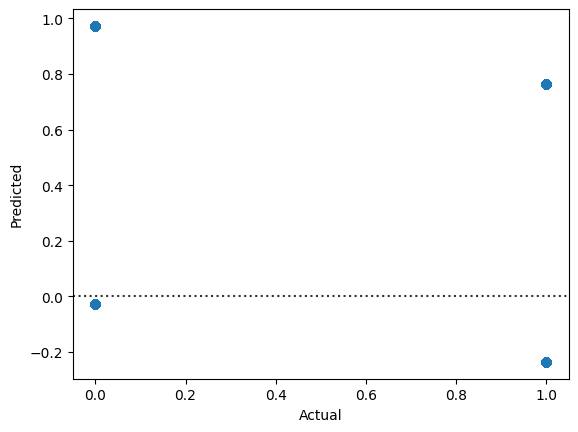

In [39]:
#residuals
sns.residplot(x='Actual',y='Predicted',data=A)
plt.show();

In [40]:
#Save the model
final_model=GaussianNB()
final_model.fit(X_train,y_train)
dump(final_model, 'adult')

['adult']

In [41]:
# Load the Model:
load_model=load('adult')
load_model

GaussianNB()

In [42]:
y_pred = load_model.predict(X_test_scale)
score = accuracy_score(y_test, y_pred)
score

0.8037670181185382

#XGBoost

In [43]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [44]:
params = {"model__learning_rate": 0.1,
          "model__n_estimators": 200,
          "objective":'binary:logistic'}

In [45]:
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]

In [46]:
n = 1000
modeloXGBoost = xgb.train(params=params,
                          dtrain=dtrain_reg,
                          num_boost_round=n,
                          evals=evals,
                          verbose_eval=100)

[0]	validation-logloss:0.45141	train-logloss:0.45431
[100]	validation-logloss:0.29804	train-logloss:0.24543
[200]	validation-logloss:0.30672	train-logloss:0.21884
[300]	validation-logloss:0.31469	train-logloss:0.20365
[400]	validation-logloss:0.32507	train-logloss:0.18631
[500]	validation-logloss:0.33166	train-logloss:0.17655
[600]	validation-logloss:0.34145	train-logloss:0.16507
[700]	validation-logloss:0.34872	train-logloss:0.15902
[800]	validation-logloss:0.35567	train-logloss:0.15256
[900]	validation-logloss:0.36472	train-logloss:0.14415
[999]	validation-logloss:0.37350	train-logloss:0.13799


In [47]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
y_pred = xgb_model.predict(X_test)

In [49]:
conf_mat = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_mat)

Matriz de confusión:
[[6953  487]
 [ 860 1469]]


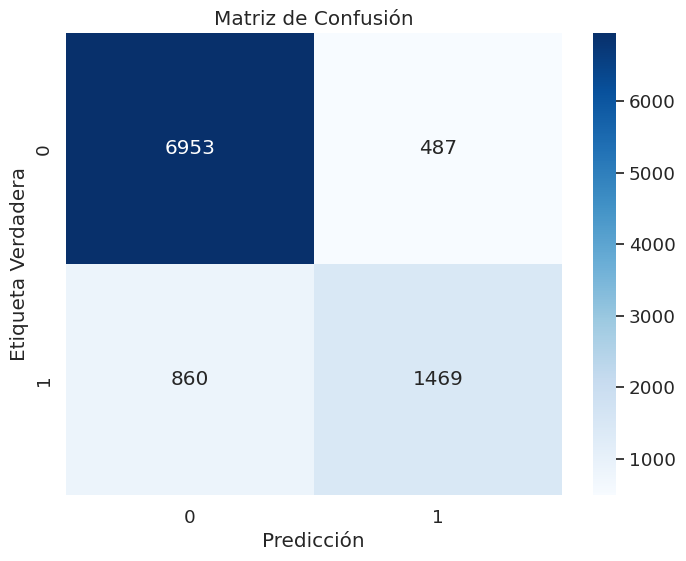

In [50]:
# Calcula la matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)



# Crea la figura y los ejes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Escala de fuente
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

# Configuración de los ejes y el título
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')

# Muestra la gráfica
plt.show()

In [51]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión modelo XGBoost:", accuracy)

Precisión modelo XGBoost: 0.8621148531067663


#Arboles de decision

In [52]:
#Definimos una malla de parametros que serviran para entrenar multiples arboles
parametros=ParameterGrid(
    {'min_samples_split':[4,6,8,10],
     'max_features':[1,2,3,4],
     'max_depth':[None,4,6,8],
     'criterion':['gini','entropy']})


resultados={'pFinal':[],'treeScore':[]}


In [53]:
#se itera sobre todos los parametros para entrenar arboles con cada uno
for parametro in parametros:
  modeloArbol=tree.DecisionTreeClassifier(random_state=454,** parametro)
  modeloArbol.fit(X_train,y_train)
  resultados['pFinal'].append(parametro)
  resultados['treeScore'].append(modeloArbol.score(X_test,y_test))
  print(f"Modelo : {parametro} ",modeloArbol.score(X_test, y_test))

Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 4}  0.8096018016173611
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 6}  0.8115467294503019
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 8}  0.8183027945542021
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 10}  0.8305865492885659
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_split': 4}  0.8151294912478247
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_split': 6}  0.8176886068174839
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_split': 8}  0.8238304841846658
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_split': 10}  0.8253659535264612
Modelo : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 4}  

In [54]:
# Analizamos los resultados
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['pFinal'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('treeScore', ascending=False)
resultados = resultados.drop(columns=('pFinal'))
resultados.head(10)

,treeScore,criterion,max_depth,max_features,min_samples_split
63,0.847784,gini,8.0,4,10
61,0.847681,gini,8.0,4,6
45,0.844815,gini,6.0,4,6
47,0.844815,gini,6.0,4,10
46,0.844815,gini,6.0,4,8
121,0.842461,entropy,8.0,3,6
58,0.842358,gini,8.0,3,8
111,0.841847,entropy,6.0,4,10
62,0.841437,gini,8.0,4,8
124,0.841028,entropy,8.0,4,4


**creamos** un modelo con el mejor arbol

In [55]:
#creamos el arbol
mejorArbol=tree.DecisionTreeClassifier(min_samples_split=10, max_features=4, max_depth=8, criterion='gini', random_state=454)

In [56]:
#Entrenar el modelo, fit()
mejorArbol.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, max_features=4, min_samples_split=10,
                       random_state=454)

In [57]:
#obtener la exactitud del arbol
scoreArbol=modeloArbol.score(X_train, y_train)
print(scoreArbol)
score=modeloArbol.score(X_test, y_test)
print(score)

0.8358634608634609
0.8302794554202068


In [58]:
#crear un DF con las prediccionesy sus valores reales
y_predictArbol=mejorArbol.predict(X_test)
y_predictArboldf=pd.DataFrame(y_predictArbol,columns=["prediccion"])
y_test_ordenado=y_test.reset_index(drop=True)
comparativo=pd.concat([y_test_ordenado,y_predictArboldf],axis=1)
print(comparativo.head(20))

    income  prediccion
0        0           0
1        0           0
2        0           0
3        0           0
4        0           0
5        0           0
6        0           0
7        0           1
8        0           0
9        0           0
10       0           0
11       0           0
12       0           0
13       1           0
14       0           0
15       0           0
16       1           0
17       0           0
18       1           0
19       0           0


crear la matriz de confusion


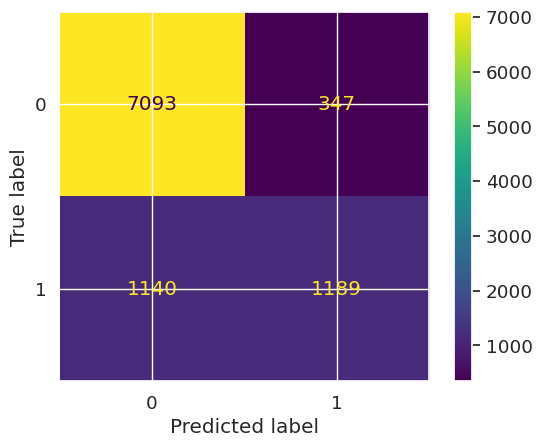

In [59]:
#Se crea una tabla con los datos de la matriz
matrixArbol=confusion_matrix(y_test,y_predictArbol)
#Grafica la matriz
mostrarMatrixArbol=ConfusionMatrixDisplay(confusion_matrix=matrixArbol,display_labels=mejorArbol.classes_)
mostrarMatrixArbol.plot()

In [60]:
print(classification_report(y_test,y_predictArbol))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      7440
           1       0.77      0.51      0.62      2329

    accuracy                           0.85      9769
   macro avg       0.82      0.73      0.76      9769
weighted avg       0.84      0.85      0.84      9769



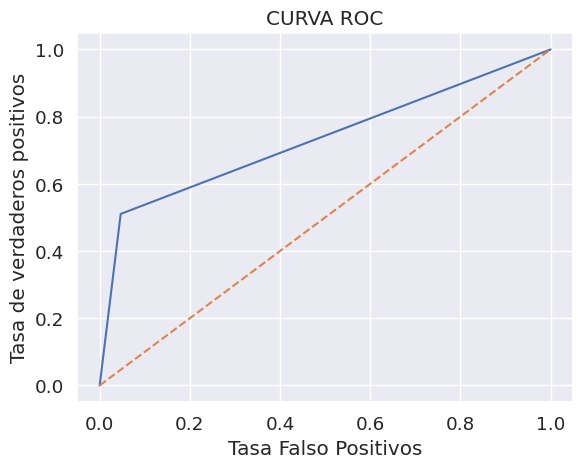

In [61]:
fprArbol,tprArbol,umbral=roc_curve(y_test,y_predictArbol)
#graficar la curva ROC
plt.plot(fprArbol,tprArbol)
plt.plot([0,1],[0,1],"--")
plt.xlabel("Tasa Falso Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")
plt.show()

In [62]:
#Area bajo la curva
print ("Area bajo la curva", auc(fprArbol,tprArbol))

Area bajo la curva 0.7319398756677147


#Random Forest

In [63]:
#definir los parametros para el bosque
param_grid= ParameterGrid(
    {'n_estimators':[60,80,100,120,150],
     'max_features':[3,4,5,7],
     'max_depth':[None,2,3,4,5],
     'criterion':['gini','entropy']})

resultadosBosque={'paramBosque':[],'rfScore':[]}





In [64]:
i=0
for p in param_grid:
   i+=1
   modeloBosque = RandomForestClassifier( oob_score=True,random_state=444,** p)
   modeloBosque.fit(X_train,y_train)
   resultadosBosque['paramBosque'].append(p)
   resultadosBosque['rfScore'].append(modeloBosque.oob_score_)
   print(f"Modelo {i} : {p} \u2713", modeloBosque.oob_score_)

Modelo 1 : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 60} ✓ 0.8366970866970866
Modelo 2 : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 80} ✓ 0.836960336960337
Modelo 3 : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 100} ✓ 0.8363460863460863
Modelo 4 : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 120} ✓ 0.8365654615654615
Modelo 5 : {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓ 0.8371797121797122
Modelo 6 : {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'n_estimators': 60} ✓ 0.8325289575289575
Modelo 7 : {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'n_estimators': 80} ✓ 0.8344155844155844
Modelo 8 : {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'n_estimators': 100} ✓ 0.8355124605124605
Modelo 9 : {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'n_estimators': 120} ✓ 0.83520

In [65]:
# Resultados del Bosque Aleatorio
resultadosBosque = pd.DataFrame(resultadosBosque)
resultadosBosque = pd.concat([resultadosBosque, resultadosBosque['paramBosque'].apply(pd.Series)], axis=1)
resultadosBosque = resultadosBosque.sort_values('rfScore', ascending=False)
resultadosBosque = resultadosBosque.drop(columns=('paramBosque'))
resultadosBosque.head()

,rfScore,criterion,max_depth,max_features,n_estimators
95,0.843893,gini,5.0,7,60
96,0.843673,gini,5.0,7,80
98,0.843454,gini,5.0,7,120
99,0.843454,gini,5.0,7,150
94,0.843410,gini,5.0,5,150


Elegimos el mejor modelo

In [66]:
finalBosque = RandomForestClassifier(n_estimators=120,criterion="gini",max_features=5,max_depth=14,oob_score=True,random_state=444)
finalBosque.fit(X,y)

print(f"Modelo {i} : {p} \u2713", finalBosque.oob_score_)

Modelo 200 : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 7, 'n_estimators': 150} ✓ 0.8559319431221399


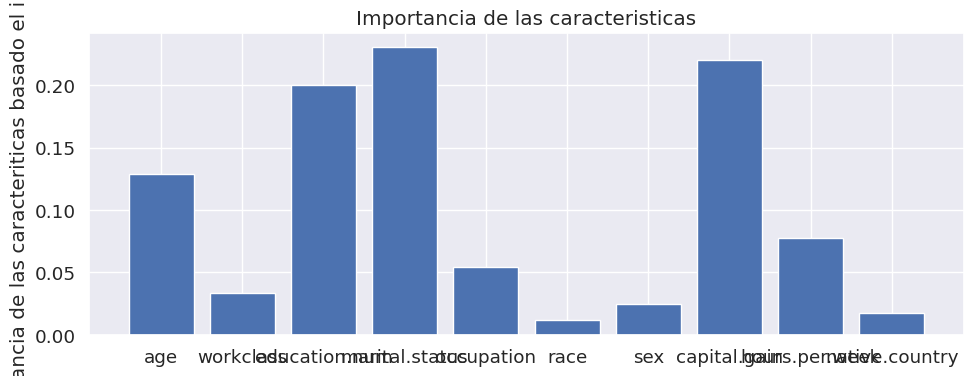

In [67]:
#Ver una grafica con la importancia de cada variable en este modelo
importancia=finalBosque.feature_importances_
features=finalBosque.feature_names_in_
importancia_pronostico=pd.Series(importancia,index=features)
fig,ax=plt.subplots(figsize=(10,4))
ax.bar(features,importancia)
ax.set_title("Importancia de las caracteristicas")
ax.set_ylabel("Importancia de las caracteriticas basado el impurity")
fig.tight_layout()

In [68]:
#obtener la exactitud del Bosque
scoreBosque=finalBosque.score(X_train, y_train)
print(scoreBosque)
score=finalBosque.score(X_test, y_test)
print(score)

0.8916286416286416
0.8920053229603849


In [69]:
#crear un DF con las prediccionesy sus valores reales
y_predictBosque=mejorArbol.predict(X_test)
y_predictBosquedf=pd.DataFrame(y_predictBosque,columns=["prediccion"])
y_test_ordenado=y_test.reset_index(drop=True)
comparativo=pd.concat([y_test_ordenado,y_predictBosquedf],axis=1)
print(comparativo.head(20))

    income  prediccion
0        0           0
1        0           0
2        0           0
3        0           0
4        0           0
5        0           0
6        0           0
7        0           1
8        0           0
9        0           0
10       0           0
11       0           0
12       0           0
13       1           0
14       0           0
15       0           0
16       1           0
17       0           0
18       1           0
19       0           0


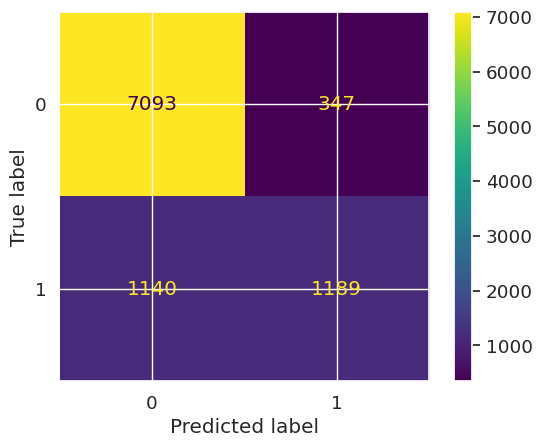

In [70]:
#Se crea una tabla con los datos de la matriz
matrixBosque=confusion_matrix(y_test,y_predictBosque)
#Grafica la matriz
mostrarMatrixBosque=ConfusionMatrixDisplay(confusion_matrix=matrixBosque,display_labels=mejorArbol.classes_)
mostrarMatrixBosque.plot()

In [71]:
print(classification_report(y_test,y_predictBosque))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      7440
           1       0.77      0.51      0.62      2329

    accuracy                           0.85      9769
   macro avg       0.82      0.73      0.76      9769
weighted avg       0.84      0.85      0.84      9769



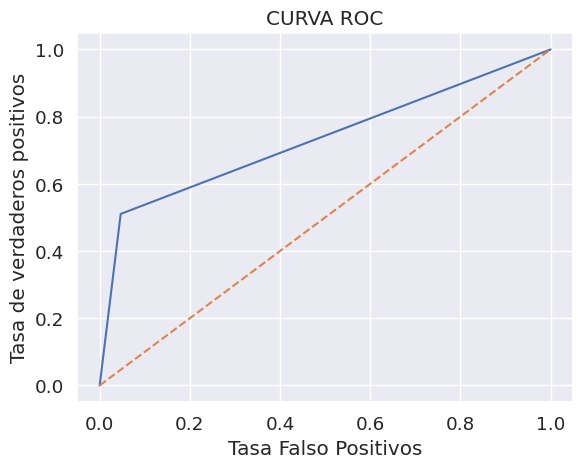

In [72]:
fprBosque,tprBosque,umbral=roc_curve(y_test,y_predictBosque)
#graficar la curva ROC
plt.plot(fprBosque,tprBosque)
plt.plot([0,1],[0,1],"--")
plt.xlabel("Tasa Falso Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")
plt.show()

In [73]:
#Area bajo la curva
print ("Area bajo la curva Bosque", auc(fprBosque,tprBosque))

Area bajo la curva Bosque 0.7319398756677147


In [74]:
#Area bajo la curva
print ("Area bajo la curva Arbol", auc(fprArbol,tprArbol))

Area bajo la curva Arbol 0.7319398756677147


Conclusión General:

XGBoost: Con una precisión de 0.862, el modelo XGBoost supera significativamente a los otros modelos en términos de precisión. Esto sugiere que XGBoost es el modelo más efectivo para este problema de predicción en particular.

Random Forest y Árboles de Decisión: Ambos modelos tienen una precisión similar de alrededor de 0.732. Esto indica que, aunque estos modelos pueden ser efectivos, su rendimiento es inferior al de XGBoost en este caso.

Naive Bayes: Con una precisión de 0.804, el modelo Naive Bayes se encuentra en una posición intermedia entre XGBoost y los modelos de árboles de decisión. Aunque supera a los modelos de árboles de decisión y bosque aleatorio, no alcanza la precisión del modelo XGBoost.

Conclusiones Específicas:

XGBoost: Este modelo demostró ser el más efectivo en términos de precisión. Su capacidad para aprender relaciones complejas en los datos y evitar el sobreajuste lo hace destacar en este problema de predicción.

Random Forest y Árboles de Decisión: Aunque estos modelos ofrecen una precisión razonable, su rendimiento es inferior al de XGBoost. Sin embargo, pueden ser opciones viables si se prefiere un modelo más simple y fácil de interpretar.

Naive Bayes: Aunque el modelo Naive Bayes no alcanza la precisión de XGBoost, su desempeño es respetable y puede ser una opción adecuada si se busca un modelo más ligero computacionalmente y con menos requisitos de ajuste.

En resumen, la elección del modelo dependerá de diversos factores, como la precisión requerida, la complejidad del problema y las limitaciones computacionales. En este caso, XGBoost emerge como el modelo preferido debido a su alta precisión, pero siempre es importante considerar otros factores antes de tomar una decisión final